In [1]:
import png
import matplotlib.pyplot as plt
import imageio

In [2]:
source_filename = 'example2.png'

In [3]:
def read_image(filepath):
    im = imageio.imread(source_filename)
    return im

In [4]:
image = read_image(source_filename)

Посмотрим на считанное изображение

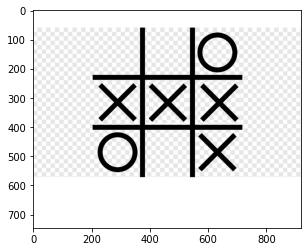

In [5]:
plt.imshow(image)
plt.show()

In [6]:
def is_black(pixel) -> bool:
    """Пиксель в формате [r, g, b, a] -> bool. True, если пиксель черный"""
    return pixel[1] < 50

In [7]:
# Для каждой колонки вычисляем количество закрашенных пикселей
# То же самое для строк

rows_weight = [sum(map(is_black, row)) for row in image]
cols_weight = []
for col_idx in range(len(image[0])):
    sum_value = 0
    for row in image:
        sum_value += is_black(row[col_idx])
    cols_weight.append(sum_value)
    

Далее задачи
1. Найти линии разметки, вертикальные и горизонтальные, чтобы ориентироваться на них. 
    Результат: x1, x2 - координаты вертикальных полос, y1, y2 - координаты горизонтальных
2. Выявить квадраты фигур (крестиков и ноликов).
    Результат: массив кортежей (x1, y1, x2, y2) - box для каждой фигуры на доске

In [8]:
def is_equal(value1, value2, eps: float=None):
    """Проверяет, равны ли значения с точностью до eps"""
    if eps is None:
        eps = max(value1, value2) * 0.03
    return abs(value1 - value2) < eps

In [9]:
def find_max_lines(lines_array):
    """Возвращает список индексов, те, где есть длинные линии, вертикальные или горизонтальные"""
    max_line_weight = max(*lines_array)
    result = []
    for i, weight in enumerate(lines_array):
        if is_equal(weight, max_line_weight):
            result.append(i)
    return result

In [10]:
# Ищем координаты вертикальных и горизонтальных полос

rows = find_max_lines(rows_weight)
cols = find_max_lines(cols_weight)

In [11]:
def get_first_positive_index(array):
    """Находит индекс первого ненулевого элемента в массиве
    Например [0, 0, 3, 4] -> 2"""
    for i, value in enumerate(array):
        if value:
            return i
    return None


In [12]:
from enum import Enum, auto
import typing as t
import math

# Вспомогательные классы

class Figure(Enum):
    """Класс фигуры на доске крестиков ноликов. Может быть одним из трех вариантов"""
    cross = auto()
    circle = auto()
    empty = auto()
    
class Point:
    """Двумерная точка или вектор"""
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __sub__(self, other):
        return Point(self.x - other.x, self.y - other.y)
    
    def __add__(self, other):
        if not isinstance(other, Point):
            other = Point(other, other)
        return Point(other.x + self.x, other.y + self.y)
    
    def __mul__(self, value):
        return Point(self.x * value, self.y * value)
    
    def __truediv__(self, value):
        return self * (1 / value)

    def __len__(self):
        return math.sqrt(self.x**2 + self.y**2)
    
    def __repr__(self):
        return f'Point({self.x}, {self.y})'
    
    def __round__(self):
        return Point(int(self.x), int(self.y))
    

In [13]:
# Посчитаем основные геометрические параметры доски на изображении
# Находим ширину одной линии, расчитывая, что все линии на рисунке одинаковой толщины

prev_row = rows[0]
end_row = None
gap = None # Размер промежутка, между двумя соседними вертикальными линиями
for value in rows[1:]:
    if value != prev_row + 1:
        end_row = prev_row + 1
        gap = value - prev_row
    prev_row = value
width = end_row - rows[0]

board_left = get_first_positive_index(cols_weight)
board_top = get_first_positive_index(rows_weight)
init_point = Point(board_left, board_top) # Самая левая верхняя точка доски


print('Ширина линии', width)
print('Размер интервала', gap)
print('Левая верхняя точка доски', init_point)

Ширина линии 17
Размер интервала 155
Левая верхняя точка доски Point(204, 60)


In [14]:
def detect_figure(image, start: Point, end: Point, width: int, gap: int) -> Figure:
    """
    По сегменту изображения возвращает тип изображенной фигуры
    """
    mid_point = (end + start) / 2
    mid_point = round(mid_point)

    # Посчитаем сумму пикселей в самом центре выделенной области
    center_delta = width // 2
    center_weight = sum(
        map(is_black, image[mid_point.y][mid_point.x - center_delta: mid_point.x + center_delta])
    )
    if center_weight > center_delta:
        # Если в центре много черных пикселей, то определяем фигуру как крест
        return Figure.cross
    
    center_lines_weight = sum(map(is_black, image[mid_point.y][start.x:end.x]))
    if center_lines_weight < width:
        # Если не было черных точек (с допущением пары случайных пикселей)
        # То в клетке ничего не содержится, она пустая
        return Figure.empty
    return Figure.circle
    

In [15]:
# Двумерным массив фигур на картинке класса Figure
figures: t.List[t.List[Figure]] = []

# Определяем конфигурацию доски, какие фигуры в каких ячейках
for row_idx in range(3):
    figures_line = []
    for col_idx in range(3):
        start = init_point + Point(col_idx, row_idx) * (width + gap)
        end = start + gap
        figures_line.append(detect_figure(image, start, end, width, gap))
    figures.append(figures_line)

In [16]:
# Выведем полученную доску

for line in figures:
    for figure in line:
        if figure == Figure.cross:
            print('X', end='')
        elif figure == Figure.circle:
            print('O', end='')
        else:
            print('_', end='')
    print()

__O
XXX
O_X


In [17]:
def get_straight_line(idx: int, init_point: Point, width: int, gap: int, is_horizontal=True):
    """
    Возвращает координаты одной линии. Горизонтальной, если is_horizontal = True
    return: (Point, Point)
    """
    distance = 2*(width + gap) + gap
    if not is_horizontal:
        return (
            Point(init_point.x + idx*(width + gap) + gap // 2, init_point.y),
            Point(init_point.x + idx*(width + gap) + gap // 2, init_point.y + distance)
        )
    return (
        Point(init_point.x, init_point.y + idx*(width + gap) + gap // 2),
        Point(init_point.x + distance, init_point.y + idx*(width + gap) + gap // 2)
    )

def get_diagonal_line(init_point: Point, width: int, gap: int, second=False):
    """
    Возвращает координаты диагональной линии на изображении
    Главной, если second == False
    Иначе побочной
    return: (Point, Point)
    """
    if not second:
        return (
            init_point,
            init_point + Point(gap*3 + width*2, gap*3 + width*2)
        )
    return (
        init_point + Point(gap*3 + width*2, 0),
        init_point + Point(0, gap*3 + width*2)
    )

In [18]:
def is_equal_row(arr: list, idx: int) -> bool:
    """Для двумерного массива фигур и данного индекса определяет, выиграшный ли ряд"""
    value = arr[idx][0]
    if value == Figure.empty:
        return False
    for item in arr[idx]:
        if item != value:
            return False
    return True

def is_equal_col(arr: list, idx: int):
    """Для двумерного массива фигур и данного индекса определяет, выиграшный ли столбец"""
    value = arr[0][idx]
    if value == Figure.empty:
        return False
    for line in arr:
        if line[idx] != value:
            return False
    return True

def is_equal_diag(arr: list, second=False):
    """Проверяем, равны ли элементы на диагонале. Главной, если second==False 
    и побочной иначе. Для массива 3 на 3"""
    if arr[1][1] == Figure.empty:
        return False
    
    if second:
        return arr[0][2] == arr[1][1] == arr[2][0]
    return arr[0][0] == arr[1][1] == arr[2][2]
        
line_begin: Point = None # Начало будущей линии
line_end: Point = None # Конец будущей линии

# Проверяем все ряды и столбца, являются ли они выиграшными
for idx in range(3):
    if is_equal_row(figures, idx):
        line_begin, line_end = get_straight_line(idx, init_point, width, gap, is_horizontal=True)
        break
        
    elif is_equal_col(figures, idx):
        line_begin, line_end = get_straight_line(idx, init_point, width, gap, is_horizontal=False)
        break
        
# Смотрим на 2 диагональных ряда. Если равны выставляем lin
if is_equal_diag(figures, second=False):
    line_begin, line_end = get_diagonal_line(init_point, width, gap, second=False)
    
elif is_equal_diag(figures, second=True):
    line_begin, line_end = get_diagonal_line(init_point, width, gap, second=True)

In [19]:
# В формате изображения черный цвет пикселя представлен в виде массива из 4 чисел
black_color = [0, 0, 0, 255]

def draw_line(image, start: Point, end: Point, width: 4):
    """
    Рисуем линию на изображении
    image: массив пикселей картинки
    width: толщина линии
    start, end - точки начала и конца линии
    """
    path_vector = end - start
    
    def draw_point(x, y):
        if y < len(image) and x < len(image[y]):
            image[y][x] = black_color
        
    if abs(end.x - start.x) > abs(end.y - start.y):
        # Рисуем более горизонтальную линии, поэтому основной цикл по x
        for x in range(start.x, end.x):
            part = x / abs(end.x - start.x) # Процент нарисованной линии
            curr_point = start + path_vector * part
            curr_y = int(curr_point.y)
            for y in range(curr_y - width // 2, curr_y + width // 2):
                draw_point(x, y)
                
    else:
        # Линия ближе к вертикальной, поэтому итерируемся по y
        for y in range(start.y, end.y):
            part = y / abs(end.x - start.x) # Процент нарисованной линии
            curr_point = start + path_vector * part
            curr_x = int(curr_point.x)
            for x in range(curr_x - width // 2, curr_x + width // 2):
                draw_point(x, y)
        

In [20]:
print(line_begin)

Point(204, 309)


In [21]:
def save_image(image, filename):
    """Сохранить картинку с названием filename"""
    imageio.imwrite(filename, image)

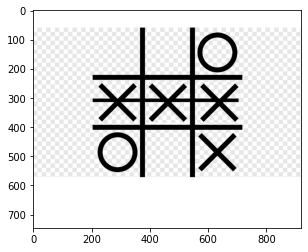

In [22]:
# Рисуем линию на изображении, если партия выигрышная
if line_begin is not None:
    result_image = image.copy()
    draw_line(result_image, line_begin, line_end, width=12)
    
    # Выводим картинку с линией
    plt.imshow(result_image)
    plt.show()
    
    save_image(result_image, 'example2_result.png')
else:
    print('Эта партия не выигрышная')